In [ ]:
import pandas as pd
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
nltk.download('all')
nltk.download('stopwords')
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import drive

In [ ]:
df = pd.read_csv('/content/amazon_top500.csv')
df.head()

,title,brand,description,price/currency,price/value,stars,reviewsCount
0,"65W Universal USB C Chromebook Charger,Replace...",NELEBUTO,NaN,$,13.69,4.2,55.0
1,"EMPSIGN Laptop Tote bag for women 16 Inch, Sty...",EMPSIGN,NaN,$,31.99,4.9,58.0
2,"100Pcs Mario Stickers, Cartoon Game Mario Stic...",MOQIAN,100Pcs Japanese Cartoon Game Mari Stickers for...,$,5.99,4.6,42.0
3,"USB Docking Station, JESWO USB 3.0 Laptop Dock...",JESWO,NaN,$,79.99,4.2,39.0
4,ANCBD C31N1824 Battery for Asus Chromebook Fli...,ANCBD,Specification: Battery Rating: 11.55V Battery ...,$,46.99,NaN,NaN


In [ ]:
df = pd.read_csv('/content/amazon_top500.csv')

#missing descriptions
for index, row in df.iterrows():
    if pd.isna(row['description']):
        df.at[index, 'description'] = row['title']

price_features = ['price/value']
# Train a KNN imputer on the entire dataset for prices
price_imputer = KNNImputer(n_neighbors=5)
price_imputer.fit(df[price_features])

# Impute missing prices
imputed_prices = price_imputer.transform(df[price_features])
df['price/value'] = imputed_prices

#missing stars
stars_features = ['stars']

# Train a KNN for stars
stars_imputer = KNNImputer(n_neighbors=5)
stars_imputer.fit(df[stars_features])

# Impute missing stars
imputed_stars = stars_imputer.transform(df[stars_features])
df['stars'] = imputed_stars.round(1)

#missing reviewsCount
reviews_features = ['reviewsCount']

# Train a KNN for reviewsCount
reviews_imputer = KNNImputer(n_neighbors=5)
reviews_imputer.fit(df[reviews_features])

# Impute missing reviewsCount
imputed_reviews = reviews_imputer.transform(df[reviews_features])
df['reviewsCount'] = imputed_reviews.round().astype(int)

# Fill missing values in the price/currency column with ' $ '
df['price/currency'].fillna(' $ ', inplace=True)

# final dataset
df.to_csv('/content/final_dataset.csv', index=False)


In [ ]:
# Display unique values and their counts for categorical columns
df = pd.read_csv('/content/final_dataset.csv')
print(df['brand'].value_counts())
print(df['price/currency'].value_counts())


Generic     12
LOVEVOOK    12
MOSISO       8
DGFTB        7
Smatree      6
            ..
JMYUJX       1
ampoock      1
bergsalz     1
Jaurney      1
MULS         1
Name: brand, Length: 345, dtype: int64
$      470
 $      30
Name: price/currency, dtype: int64


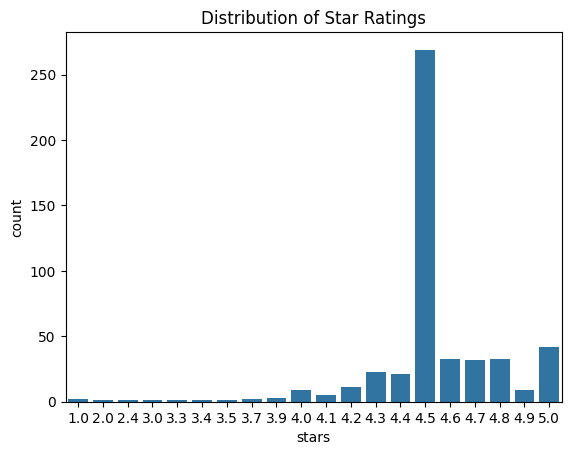

In [ ]:
sns.countplot(x='stars', data=df)
plt.title('Distribution of Star Ratings')
plt.show()

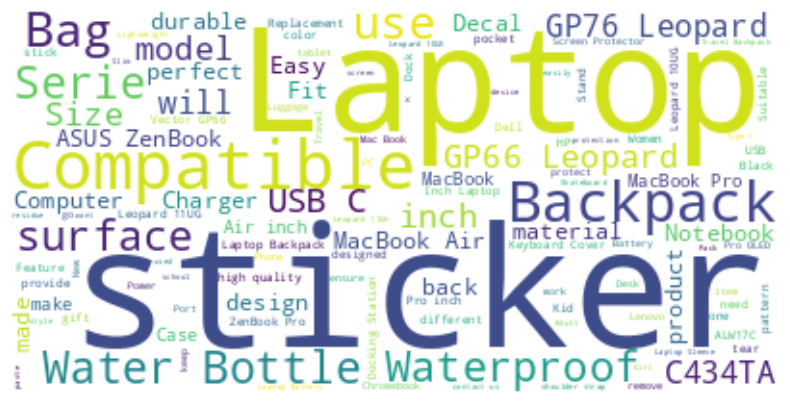

In [ ]:
# Convert non-string values to empty strings in the 'description' column
df['description'] = df['description'].astype(str)

# Join all descriptions into a single string
comment_words = ' '.join(df['description'])

# Generate WordCloud
wordcloud = WordCloud(width=400, height=200, background_color='white').generate(comment_words)

# result
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

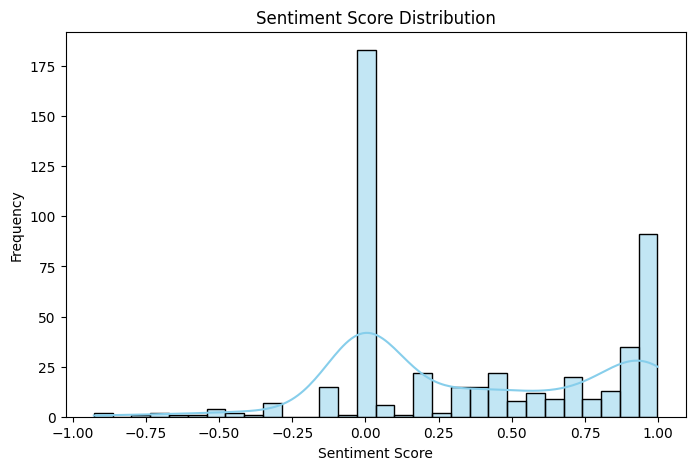

In [ ]:
# Convert non-string values to empty strings in the 'description' column
df['description'] = df['description'].astype(str)

# Sentiment Analysis
sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['description'].apply(lambda x: sia.polarity_scores(x)['compound'])

# result
plt.figure(figsize=(8, 5))
sns.histplot(df['sentiment_score'], bins=30, kde=True, color='skyblue')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

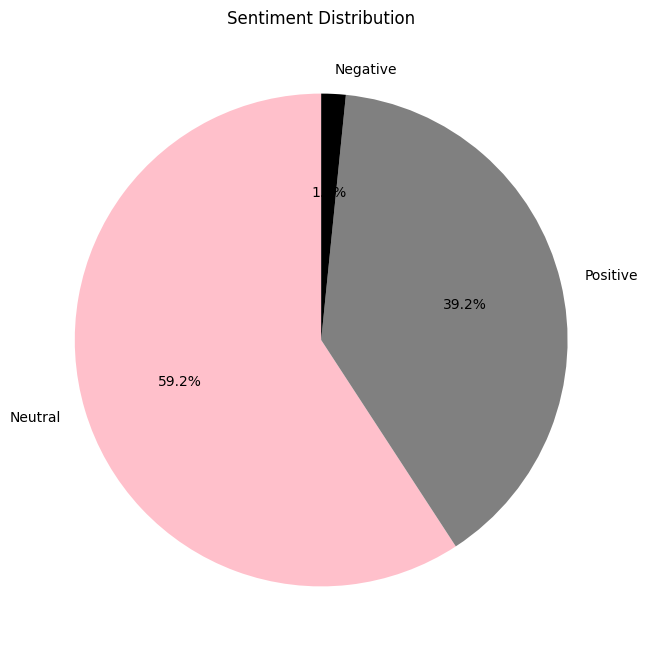

In [ ]:
# Categorize sentiment scores
df['sentiment_category'] = pd.cut(df['sentiment_score'], bins=[-1, -0.5, 0.5, 1], labels=['Negative', 'Neutral', 'Positive'])

# Calculate the distribution of sentiment categories
sentiment_distribution = df['sentiment_category'].value_counts()

# result
plt.figure(figsize=(8, 8))
plt.pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%', colors=['pink', 'grey', 'black'], startangle=90)
plt.title('Sentiment Distribution')
plt.show()

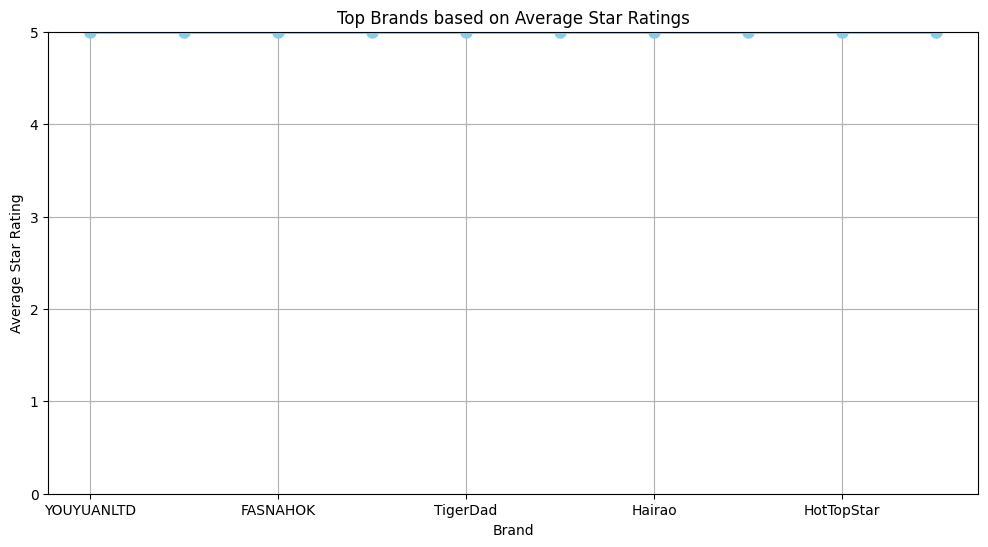

In [ ]:
average_stars_per_brand = df.groupby('brand')['stars'].mean()

top_brands = average_stars_per_brand.sort_values(ascending=False).head(10)

# Plotting the Top Brands based on average star ratings using a line chart
plt.figure(figsize=(12, 6))
top_brands.plot(kind='line', marker='o', color='skyblue', linestyle='-', linewidth=2, markersize=8)
plt.title('Top Brands based on Average Star Ratings')
plt.xlabel('Brand')
plt.ylabel('Average Star Rating')
plt.ylim(0, 5)  # Set y-axis limit to represent star ratings (0 to 5)
plt.grid(True)
plt.show()

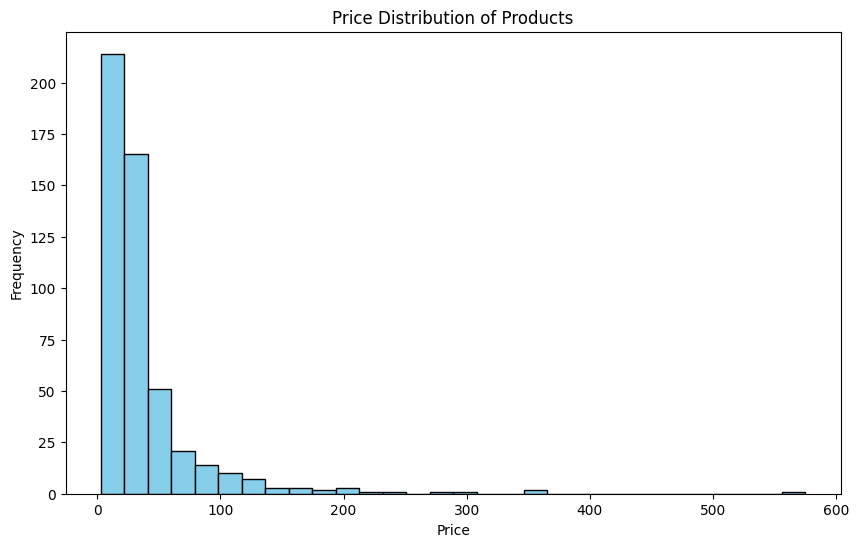

In [ ]:
df = df.dropna(subset=['price/value'])
df = df[df['price/value'] > 0]

# Plotting the Price Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['price/value'], bins=30, color='skyblue', edgecolor='black')
plt.title('Price Distribution of Products')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Group by brand and count the number of descriptions for each brand
brand_description_counts = df.groupby('brand').agg({'description': 'count'}).sort_values('description', ascending=False)

print(brand_description_counts)


          description
brand                
LOVEVOOK           12
Generic            12
MOSISO              8
DGFTB               7
Smatree             6
...               ...
JGTM                1
JESWO               1
Inateck             1
Icicrim             1
wonfurd             1

[345 rows x 1 columns]


In [ ]:
corpus = df['description'].astype(str)

# Tokenization and removing stop words
stop_words = set(stopwords.words('english'))
vectorizer = TfidfVectorizer(stop_words='english')  # Specify 'english' here
X = vectorizer.fit_transform(corpus)

# word with their corresponding TF-IDF scores
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = X.sum(axis=0).A1

# Create a DataFrame with feature names and TF-IDF scores
keywords_df = pd.DataFrame({'Keyword': feature_names, 'TF-IDF Score': tfidf_scores})

# Sort DataFrame by TF-IDF scores in descending order
keywords_df = keywords_df.sort_values('TF-IDF Score', ascending=False)

#result
top_keywords = keywords_df.head(10)
print(top_keywords)

         Keyword  TF-IDF Score
1626    backpack     26.425090
3961      laptop     25.637077
5412    stickers     24.676703
241           15     17.793763
3724        inch     17.361439
1630         bag     17.183185
5806         usb     16.309074
1885        case     13.757747
5933  waterproof     12.028528
4105     macbook     11.876553


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Colab Notebooks


/content/drive/MyDrive/Colab Notebooks


In [5]:
!git clone https://github.com/malakkkamrr/Natural-Language-Processing-Project.git


Cloning into 'Natural-Language-Processing-Project'...


In [6]:
!cp NLP PROJECT.ipynb https://github.com/malakkkamrr/Natural-Language-Processing-Project.git

cp: target 'https://github.com/malakkkamrr/Natural-Language-Processing-Project.git' is not a directory
